<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

## Task 1: Project Overview and Import Libraries

In [28]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


## Task 2: Load and Preprocess the Data

In [29]:
#fashion MNIST prepackaged in the keras API 
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()
#PIXEL VALUES RANGES 0 FROM  TO  255 PROBLEM IF WE DON'T NORMALIZE THE PIXEL VALUES 
#NOT NORMALIZING SO MODEL PROCESS LARGER WEIGHT VALUES LEAD TO SLOWER CONVERGENCE AND POOR PERFORMANCE 
#BEST PRACTICE TO NORMLIZE BY DEVIDING THEM BY 255

x_train=x_train.astype(np.float32)/255.0  
x_test=x_test.astype(np.float32)/255.0

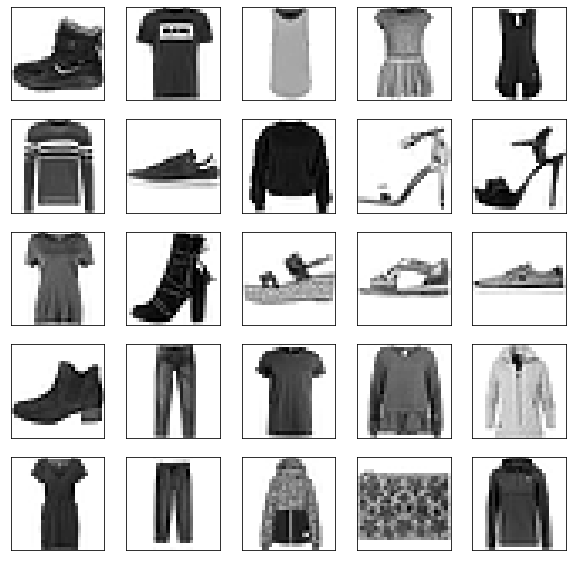

In [30]:
#PLOT WITH RANDOM IMAGES FROM THE DATASET  5 BY 5
plt.figure(figsize=(10,10))
for i in range (25):
    plt.subplot(5,5,i+1)
    #NOT HAVE X AND Y TICKS 
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #AS MNIST ARE GRAY TELL CMAP WHITE AND BLACK IMAGES 
    plt.imshow(x_train[i],cmap=plt.cm.binary)
plt.show()

## Task 3: Create Batches of Training Data

In [31]:
#USE DCGAM TO LEARN A MAPPING FROM A RANDOM GAUSSIAN NOISE TO IMAGES OF THIS DISTRIBUTION SO WE GET IMAGES THAT ARE AS CLOSE TO 
#GROUND TRUTH AS POSSIBLE 

batch_size=32 #FIT GPU OF THE CLOUD DESKTOP 
dataset=tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000)

#combine random elements into batches 
dataset=dataset.batch(batch_size,drop_remainder=True).prefetch(1)#from dataset
#tensorflow ignroe last batch ti get a full shape propagation 


## Task 4: Build the Generator Network for DCGAN

![GAN](DCGAN.png)

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [32]:

num_features=100 
#use keras sequential api to create our generator model 
generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128,input_shape=[num_features]),
    keras.layers.Reshape([7,7,128]),
    keras.layers.BatchNormalization(),
    #isng convd trnaspose layers which is an upsamlping layer to produce an image from a given seed  random noise 
    #upsample multiple size until 28*28*1 size 
    keras.layers.Conv2DTranspose(64,(5,5),(2,2),padding="same",activation='selu'),
    # activation function in 2016 it was recommended to use relu 
    #in recent research papers using scale exponential linear uNit greattly improves the convergence speed 
    #of the DCGan s structure 
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1,(5,5),(2,2),padding="same",activation='tanh')
    
    
])

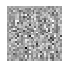

In [33]:
noise=tf.random.normal(shape=[1,num_features])
generated_image=generator(noise,training=False)
plot_utils.show(generated_image,1)
#MODEL LEARNED TO TRNASFORM RANDOM NOISE TO IMAGES LIKE OF THE DATASET

## Task 5: Build the Discriminator Network for DCGAN

In [34]:
#CNN BASED BINARY CLASSIFIER 
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64,(5,5),(2,2),input_shape=[28,28,1],padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128,(5,5),(2,2),padding="same"),
     keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1,activation='sigmoid')
    
    
    
])

In [35]:
decision=discriminator(generated_image) #1 REAL IMAGE 0 CLOSE  GENERATED IMAGE 
print(decision)

tf.Tensor([[0.4984329]], shape=(1, 1), dtype=float32)


## Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [36]:
discriminator.compile(loss='binary_crossentropy',optimizer='rmsprop')
discriminator.trainable=False
gan=keras.models.Sequential([generator,discriminator])
gan.compile(loss='binary_crossentropy',optimizer='rmsprop')


## Task 7: Define Training Procedure

In [37]:
seed=tf.random.normal(shape=[batch_size,100])
#TRAINING PROCEDURE CREATE SEED OF RANDOM GAUSSIAN NOISE TRACK HOPEFULLY IMRPVE OVER VARIOUS EPOCHQ OF TRAINING THE GIF 

In [44]:
#TRAIN DISCRIMANTOR THEN THE GENERATOR 
def train_dcgan(gan,dataset,batch_size,num_features,epochs=5):
    generator,discriminator = gan.layers
    for epoch in tqdm (range(epochs)):
        print("Epochs {}/{}".format(epoch+1,epochs))
        for X_batch in dataset:
            #MINI BATCHES OF FAKE IMAGES 
            noise = tf.random.normal(shape=[batch_size,num_features])
            generated_images=generator(noise)
            X_fake_and_real=tf.concat([generated_images,X_batch],axis=0)
            #CONCATENATE GENERATED IMAGED WITH REAL IMAGES
            y1=tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
            discriminator.trainable=False
            discriminator.train_on_batch(X_fake_and_real,y1)
            
            y2=tf.constant([[1.]]*batch_size)
            discriminator.trainable=False
            gan.train_on_batch(noise,y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch+1,seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

In [45]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Task 8: Train DCGAN

In [46]:
x_train_dcgan=x_train.reshape(-1,28,28,1)* 2. -1


In [47]:
batch_size=32
dataset=tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset=dataset.batch(batch_size,drop_remainder=True).prefetch(1)

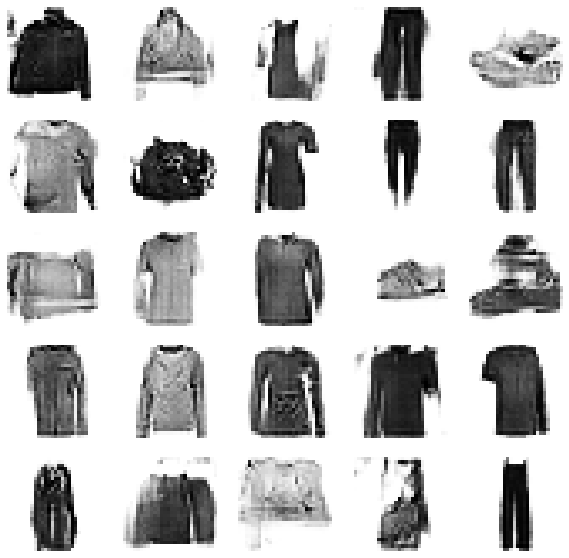

  6%|▌         | 3/50 [01:09<18:09, 23.17s/it]

Epochs 4/50


In [ ]:
%%time 
train_dcgan(gan,dataset,batch_size,num_features,epochs=50)#on my gpu try 50

## Task 9: Generate Synthetic Images with DCGAN

In [ ]:
noise=tf.random.normal(shape=[batch_size,num_features])
generated_images=generator(noise)
plot_utils.show(generated_images,8)

In [ ]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)
#gans don't work with an explicit dense function take a gan theoretical approach learn to generate 
#from a training distribution to a 